In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mr_forecast as mr

import json
import os
from astropy.utils.data import download_file
from astropy.io import ascii
from astropy.table import QTable
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.nasa_exoplanet_archive import NasaExoplanetArchiveClass
#has built-in method to get confirmed planets table; need to add method to get KOI table.

KOI_CSV_URL = ('https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=*')

def get_KOI_table(self, cache=True, show_progress=True,
                    table_path=None, all_columns=False):
        """
        Download (and optionally cache) the `NExScI Exoplanet Archive KOI
        table.

        The Exoplanet Archive table returns lots of columns of data. A full
        description of the columns can be found `here
        <https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html>`_

        Parameters
        ----------
        cache : bool (optional)
            Cache exoplanet table to local astropy cache? Default is `True`.
        show_progress : bool (optional)
            Show progress of exoplanet table download (if no cached copy is
            available). Default is `True`.
        table_path : str (optional)
            Path to a local table file. Default `None` will trigger a
            download of the table from the internet.
        all_columns : bool (optional)
            Return all available columns. The default returns only the
            columns in the default category at the link above.

        Returns
        -------
        table : `~astropy.table.QTable`
            Table of KOI properties.
        """
        if self._table is None or not cache:
            if table_path is None:
                exoplanets_url = KOI_CSV_URL
                if all_columns:
                    exoplanets_url = KOI_CSV_URL + '&select=*'

                table_path = download_file(exoplanets_url, cache=cache,
                                           show_progress=show_progress,
                                           timeout=120)
            exoplanets_table = ascii.read(table_path)

            # Create sky coordinate mixin column
            exoplanets_table['sky_coord'] = SkyCoord(ra=exoplanets_table['ra_str'],
                                                     dec=exoplanets_table['dec_str'],
                                                    unit=(u.hourangle, u.deg))

            # Assign units to columns where possible
            for col in exoplanets_table.colnames:
                if col in self.param_units:
                    # Check that unit is implemented in this version of astropy
                    if hasattr(u, self.param_units[col]):
                        exoplanets_table[col].unit = u.Unit(self.param_units[col])

            self._table = QTable(exoplanets_table)

        return self._table
    
# add this method to the NasaExoplanetArchive class
NasaExoplanetArchiveClass.get_KOI_table = get_KOI_table

NasaExoplanetArchive = NasaExoplanetArchiveClass()

%matplotlib inline

## Definitions of fields can be found at:

## confirmed planets:
#### https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html

## KOIs:
#### https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

In [2]:
#read in table from Jingjing's 2018 paper to get forecasted masses for KOIs
#Column 1 = KOI number
#Column 2 = Planet flag where the first letter gives the modal planet classification 
#           ("T"=Terran, "N"=Neptunian, "J"=Jovian, "S"=Stellar), 
#           and the second letter denotes NEA KOI disposition where "f" is a false-positive, 
#           "c" is a candidate and "v" is validated/confirmed.
#Column 3 = Log-base-10 of the measured planetary radius in Earth radii, quoted as the [-2,-1,0,+1,+2] sigma quantiles
#Column 4 = Log-base-10 of the forecasted planetary mass in Earth masses, quoted as the [-2,-1,0,+1,+2] sigma quantiles

ms = ascii.read("./forecastedKOImasses/Table2.dat",delimiter=' ')

ms.rename_column('col1', 'KOI')
ms.rename_column('col2', 'Flag')
ms.rename_column('col3', 'Rp')
ms.rename_column('col4', 'Mp')


In [3]:
KOIs = NasaExoplanetArchive.get_KOI_table()
#preliminary cuts: 
# disposition using kepler data == CANDIDATE
# several key quantities defined
# radius less than 500 R_earth
KOIs = KOIs[KOIs['koi_pdisposition'] == 'CANDIDATE']

KOIs = KOIs[np.isfinite(np.array(KOIs['koi_steff']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_slogg']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_smet']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_ror']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_prad']))]
KOIs = KOIs[KOIs['koi_prad'] > 0.]
KOIs = KOIs[KOIs['koi_prad'] < 100.]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_insol']))]
KOIs = KOIs[KOIs['koi_insol'] > 0.]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_srad']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_smass']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_period']))]

#print(KOIs.colnames)
#plt.hist(KOIs['koi_slogg'])
#plt.show()
print(len(KOIs))

4588


In [4]:
# plotting to see what difference our cuts made

#KOIs2 = ascii.read("./KOIs_chen2018_goodSystems_incJupiters.csv")

#print('available fields:')
#for key in KOIs.keys():
#    print(key)
    

In [5]:
#fig = plt.figure(figsize=(6,6))
#plt.plot(KOIs['koi_period'],KOIs['koi_prad'],'k.',alpha=0.25)
#plt.plot(KOIs2['koi_period'],KOIs2['koi_prad'],'r.',alpha=0.25)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim([0.1,1000])
#plt.ylim([10**(-0.4),10**1.2])
#plt.show()

4588
2324.01 1.55 0.0 0.0
2671.01 59.5 0.0 0.0
3429.04 1.85 0.29 -0.29
2243.03 4.55 0.93 -0.77
2924.02 1.88 0.18 -0.21
2263.03 1.08 0.34 -0.11
2926.05 3.47 0.22 -0.16
2264.02 0.91 0.1 -0.03
4146.02 0.57 0.07 -0.06
1236.04 4.13 0.69 -0.92
2298.03 0.36 0.02 -0.02
3091.02 1.13 0.36 -0.12
4288.04 0.75 0.12 -0.12
4260.04 1.16 0.05 -0.01
1353.03 2.94 0.46 -0.38
317.02 0.99 0.17 -0.09
1613.03 0.85 0.04 -0.03
2593.02 0.68 0.11 -0.07
3209.02 1.9 0.41 -0.61
787.03 0.93 0.14 -0.07
1815.02 1.24 0.79 -0.72
0.0004812818000994312
3.427591913786668


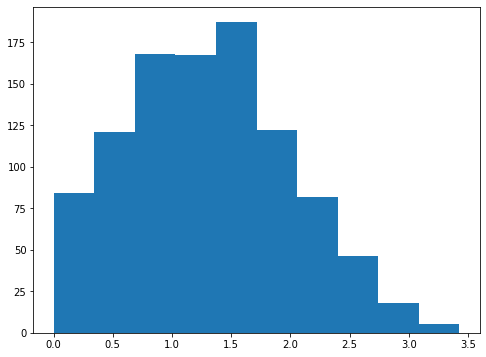

Radius range out of model expectation. Returning None.
3226.02 1.51 0.28 -0.21
929.02 1.23 0.42 -0.17
0.03700386302573255
2.2406648719702815


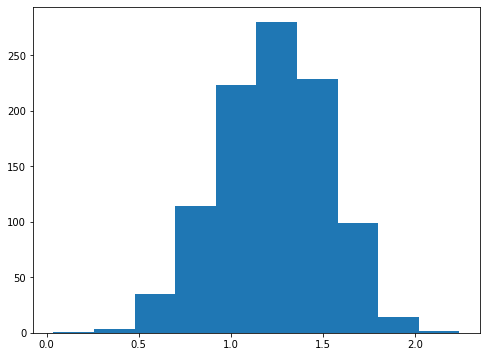

Radius range out of model expectation. Returning None.
1910.02 1.15 0.06 -0.09
2678.02 0.48 0.05 -0.03
1942.02 1.66 0.24 -0.12
2871.04 0.99 0.14 -0.15
331.02 23.26 3.66 -5.49
1083.02 0.96 0.28 -0.09
2174.04 0.96 0.04 -0.05
2906.03 1.23 0.23 -0.2
7624.01 5.92 0.79 -2.39
4773.02 0.75 0.12 -0.08
4846.02 1.26 0.34 -0.11
4896.02 1.48 0.47 -0.2
4838.03 1.1 0.09 -0.09
5007.02 2.27 0.52 -0.98
7628.01 0.69 0.09 -0.06
7630.01 0.78 0.05 -0.04
547.03 1.11 0.06 -0.1
548.02 0.86 0.14 -0.08
7378.02 3.58 0.29 -0.32
4388.02 2.47 0.69 -1.5
0.011333351840062456
6.297934574463323


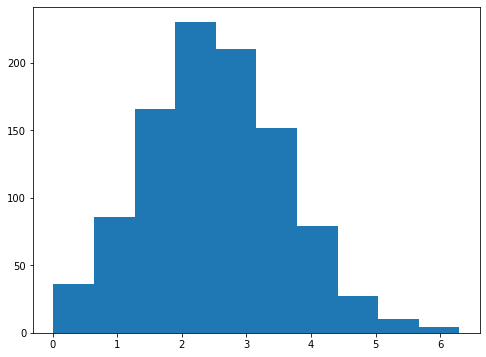

Radius range out of model expectation. Returning None.
4577.02 0.79 0.23 -0.06
7621.01 1.86 0.33 -0.36
4622.02 0.73 0.04 -0.03
4692.02 0.72 0.2 -0.05
4700.02 1.83 0.39 -0.16
7636.01 0.73 0.11 -0.07
7638.01 1.47 0.33 -0.38
7634.01 15.11 3.13 -5.82
7635.01 1.59 0.46 -0.31
7644.01 0.81 0.2 -0.12
7648.01 0.8 0.07 -0.06
7641.01 1.36 0.49 -0.61
0.007974779460747206
3.027526842363983


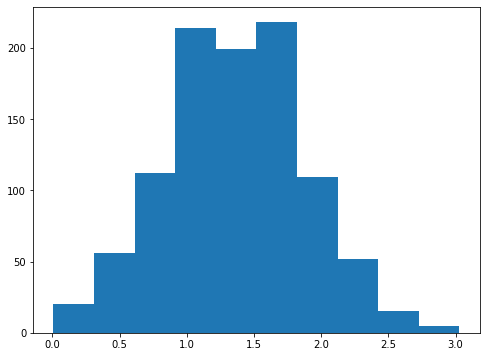

Radius range out of model expectation. Returning None.
0.07269230013471506
2.6241602020979258


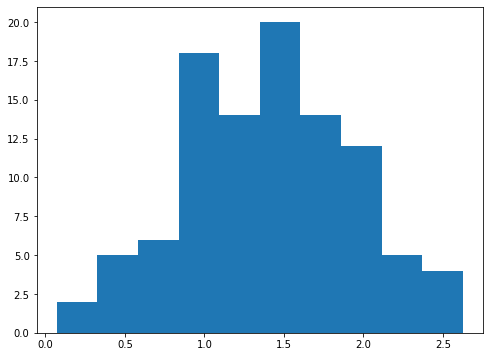

Radius range out of model expectation. Returning None.
7645.01 0.55 0.08 -0.07
7673.01 1.87 1.17 -0.96
0.013477889672019128
5.9881449406598195


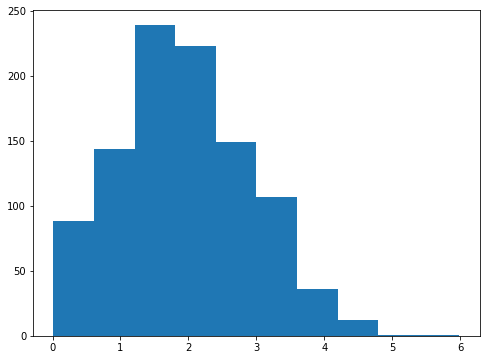

Radius range out of model expectation. Returning None.
4290.01 0.79 0.12 -0.12
7662.01 3.98 0.57 -1.69
0.09688268809244693
7.4031434677929004


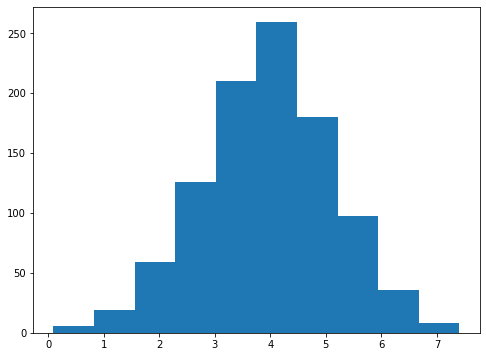

Radius range out of model expectation. Returning None.
7668.01 1.47 0.45 -0.19
566.03 1.32 0.41 -0.14
7670.01 1.18 0.33 -0.11
7679.01 0.7 0.14 -0.07
7685.01 1.35 0.39 -0.31
0.0649889683303777
2.3950401135443062


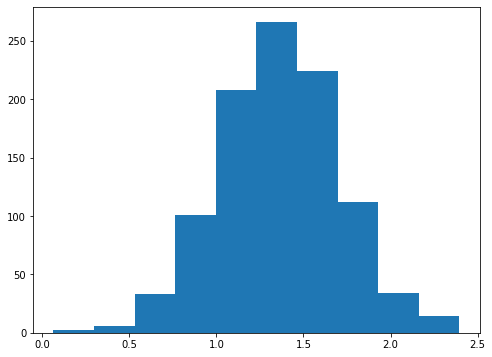

Radius range out of model expectation. Returning None.
7680.01 2.66 0.85 -0.56
7681.01 0.92 0.17 -0.07
4713.01 1.36 0.0 0.0
7693.01 1.4 0.32 -0.13
7685.02 1.08 0.3 -0.25
7676.01 0.62 0.19 -0.05
7687.01 2.66 0.47 -0.86
7678.01 0.79 0.12 -0.14
7712.01 1.06 0.37 -0.13
7703.01 1.96 0.61 -0.22
7704.01 1.0 0.32 -0.12
7706.01 1.19 0.08 -0.16
3206.01 1.38 0.0 0.0
7715.01 1.12 0.32 -0.11
7716.01 1.27 0.25 -0.1
7708.01 1.82 0.58 -0.38
7700.01 3.13 0.98 -0.33
7711.01 1.31 0.34 -0.12
7746.01 2.27 0.69 -0.24
7764.01 2.83 0.45 -0.83
7735.01 4.05 0.69 -1.49
7780.01 1.52 0.31 -0.47
7749.01 1.89 0.12 -0.19
7750.01 5.03 0.95 -1.76
7773.01 1.04 0.19 -0.11
7729.01 1.57 0.32 -0.29
7774.01 1.14 0.31 -0.1
7759.01 1.92 0.28 -0.43
7775.01 3.46 2.21 -2.21
0.016049202791771133
10.679171942901858


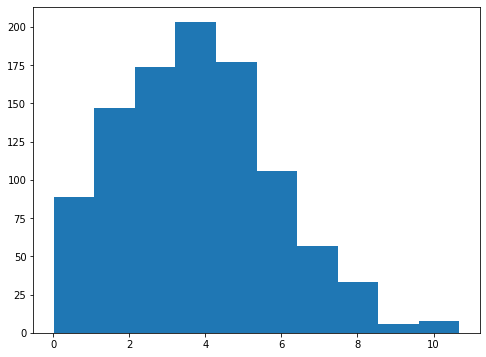

Radius range out of model expectation. Returning None.
7733.01 4.52 0.42 -2.35
7776.01 3.15 0.23 -0.29
7744.01 1.34 0.46 -0.15
7762.01 1.38 0.43 -0.14
7793.01 0.46 0.02 -0.03
7795.01 0.97 0.19 -0.09
7796.01 0.94 0.31 -0.11
7785.01 2.07 0.33 -0.25
7798.01 2.15 0.73 -0.24
7849.01 0.84 0.23 -0.12
7850.01 3.0 0.85 -0.34
7818.01 1.53 0.28 -0.53
7842.01 0.7 0.22 -0.12
7843.01 0.79 0.17 -0.07
7832.01 0.68 0.21 -0.07
7833.01 2.22 0.65 -0.22
7834.01 1.0 0.3 -0.1
7835.01 0.87 0.23 -0.08
7846.01 1.28 0.4 -0.14
7847.01 3.93 1.05 -1.4
0.07567828243971642
8.534553316086575


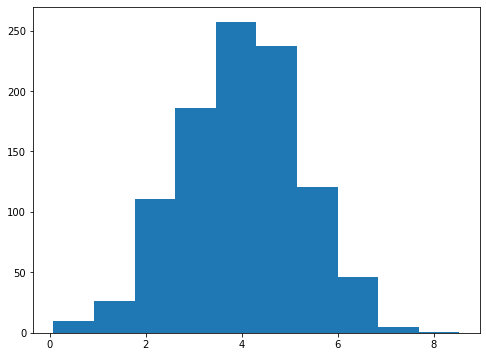

Radius range out of model expectation. Returning None.
3138.01 0.49 0.0 0.0
5226.01 4.42 0.0 0.0
5718.01 5.2 0.0 0.0
5922.01 2.15 0.71 -0.24
6180.02 1.5 0.67 -0.38
0.024944594382883212
3.229218133418386


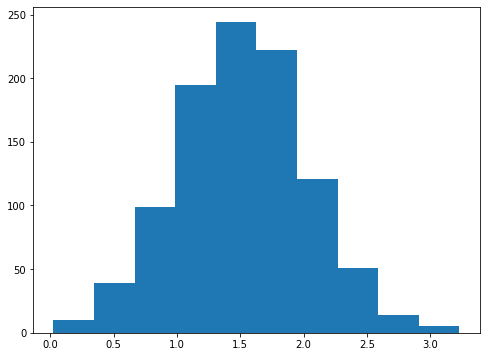

Radius range out of model expectation. Returning None.
6097.02 1.7 0.91 -0.35
0.025904733679186887
4.020367170405836


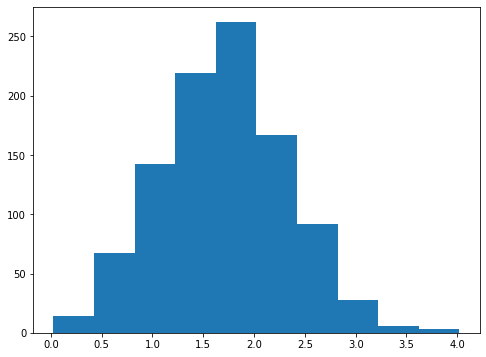

Radius range out of model expectation. Returning None.
6097.03 2.35 1.25 -0.49
0.07917132206730226
6.4376945472439715


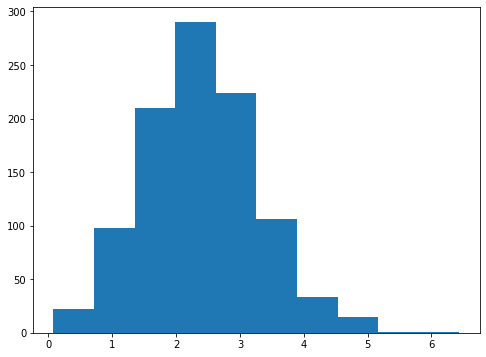

Radius range out of model expectation. Returning None.
6097.04 1.51 0.82 -0.31
0.08635329952253423
3.3543545890038393


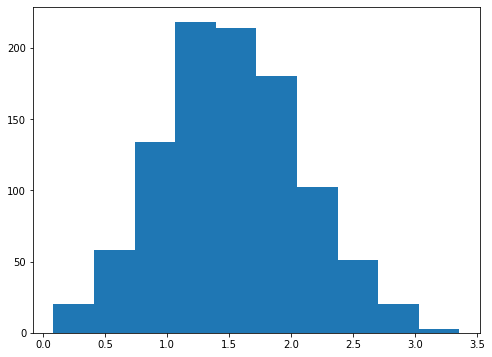

Radius range out of model expectation. Returning None.
7859.01 0.93 0.13 -0.12
7865.01 61.49 38.97 -38.97
0.0027006070810102756
182.24957374445347


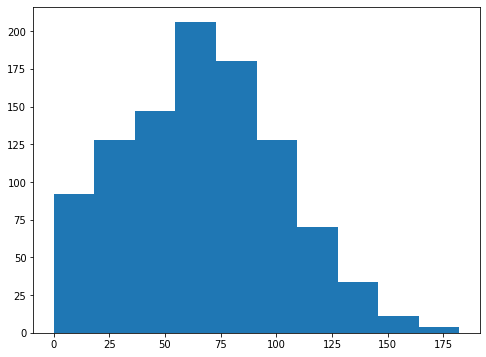

Radius range out of model expectation. Returning None.
0.2535674351111865
150.86735634511595


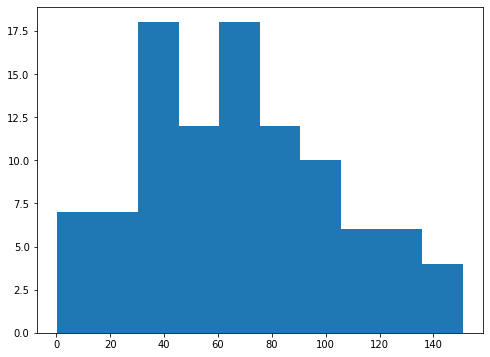

Radius range out of model expectation. Returning None.
33.944637976197754
125.54894515347371


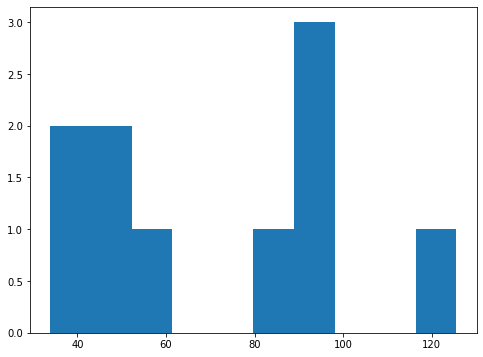

Radius range out of model expectation. Returning None.
7873.01 0.57 0.16 -0.06
7863.01 0.52 0.14 -0.06
3283.03 1.72 0.22 -0.13
7875.01 1.32 0.39 -0.17
3283.02 1.34 0.14 -0.1
2311.03 1.39 0.2 -0.06
6242.03 1.3 0.77 -0.21
0.028367001290678484
2.840786527742403


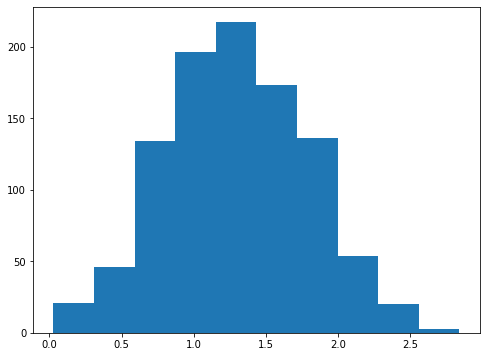

Radius range out of model expectation. Returning None.
7870.01 2.1 0.6 -0.4
7878.01 15.41 5.92 -10.99
6618.01 0.94 0.3 -0.09
7882.01 1.31 0.08 -0.12
6753.01 13.11 1.98 -4.57
6889.01 0.63 0.23 -0.12
0.06359496235725604
1.1063512674730662


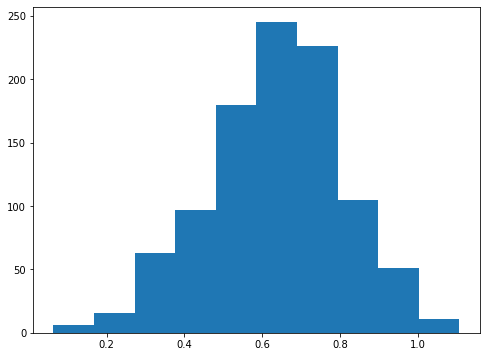

Radius range out of model expectation. Returning None.
6890.01 0.72 0.1 -0.07
6892.01 1.87 0.29 -0.35
7023.01 0.72 0.03 -0.07
7157.01 1.17 0.33 -0.36
7283.01 1.69 0.86 -0.23
0.06703642399344956
3.486666539757225


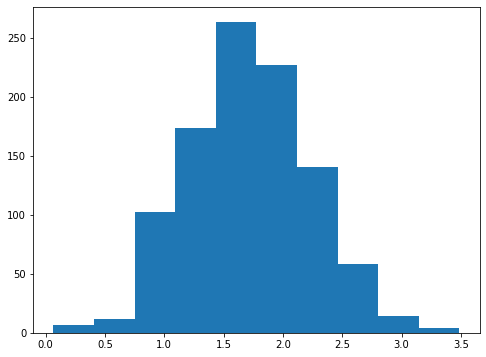

Radius range out of model expectation. Returning None.
7894.01 1.62 0.49 -0.15
4526.02 2.09 0.35 -0.38
4535.02 0.78 0.17 -0.08
4838.02 7.62 0.69 -0.62
4871.02 0.76 0.35 -0.13
0.0002709609035835836
1.5416663150622079


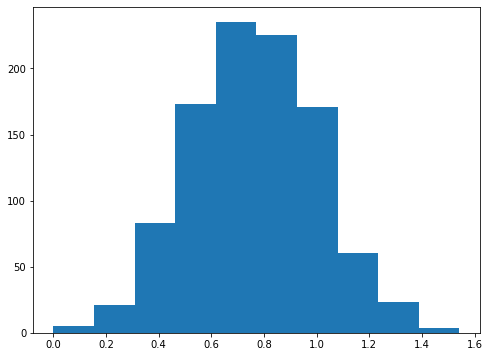

Radius range out of model expectation. Returning None.
6368.01 1.78 0.49 -0.21
6372.01 1.11 0.48 -0.1
6375.01 0.97 0.28 -0.08
6631.01 0.48 0.05 -0.04
6762.01 0.98 0.35 -0.15
0.054842637520630566
1.7833367197992502


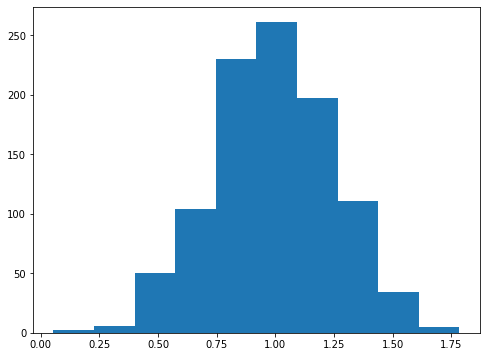

Radius range out of model expectation. Returning None.
6763.01 0.56 0.08 -0.05
6765.01 1.3 0.39 -0.16
7032.01 0.61 0.09 -0.03
7162.01 2.02 0.4 -0.5
7291.01 3.37 0.6 -1.21
7426.01 0.97 0.1 -0.1
7427.01 0.78 0.22 -0.13
7430.01 18.94 3.99 -9.98
7432.01 1.03 0.31 -0.18
460.02 1.24 0.43 -0.21
5875.02 1.88 0.59 -0.25
6253.01 1.4 0.54 -0.1
6384.01 2.79 1.07 -0.22
6635.01 1.49 0.19 -0.18
6641.01 1.16 0.34 -0.11
6774.01 26.55 7.7 -4.14
6776.01 1.45 0.44 -0.17
6777.01 1.08 0.1 -0.1
6904.01 1.28 0.28 -0.1
6907.01 1.14 0.12 -0.12
7040.01 2.18 0.76 -0.11
7041.01 0.79 0.12 -0.09
7169.01 0.72 0.23 -0.12
7174.01 0.37 0.03 -0.04
7301.01 1.19 0.11 -0.09
7305.01 0.8 0.03 -0.02
7434.01 0.95 0.2 -0.08
7435.01 0.82 0.13 -0.06
7437.01 0.84 0.2 -0.09
6256.01 1.37 0.19 -0.13
6259.01 1.14 0.31 -0.22
6259.02 1.3 0.36 -0.24
6511.01 1.46 0.57 -0.13
6513.01 1.17 0.11 -0.11
6516.01 0.88 0.12 -0.08
6646.01 1.38 0.1 -0.14
6781.01 0.93 0.43 -0.1
0.04815168697789485
1.7254412960420114


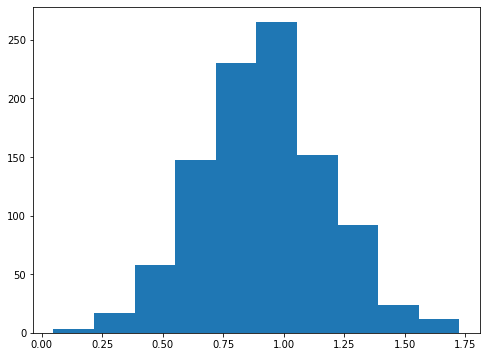

Radius range out of model expectation. Returning None.
6783.01 1.31 0.4 -0.13
6786.01 3.0 0.87 -0.3
6913.02 3.86 0.53 -1.36
7179.01 1.18 0.49 -0.22
7180.01 3.94 2.55 -1.93
0.015540211320258734
10.856405642782827


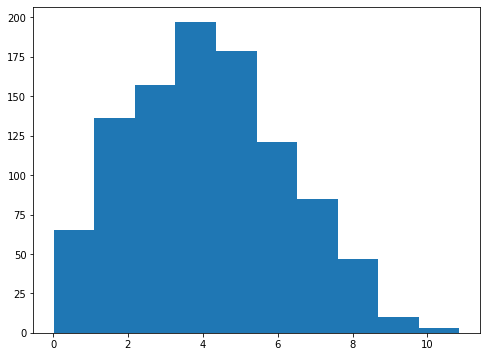

Radius range out of model expectation. Returning None.
7182.01 1.74 0.06 -0.14
547.02 0.97 0.28 -0.06
7445.01 1.3 0.25 -0.1
6262.01 1.29 0.44 -0.09
6263.01 3.33 0.61 -2.47
0.05391966867399134
8.27168596414374


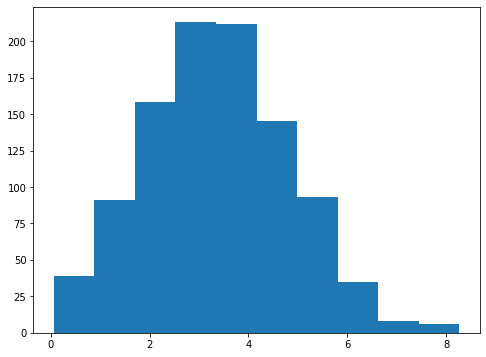

Radius range out of model expectation. Returning None.
6267.01 1.12 0.18 -0.14
6399.01 1.24 0.34 -0.23
6401.01 41.53 7.99 -9.77
6526.01 9.3 0.57 -2.36
6653.01 1.22 0.47 -0.09
6657.01 1.54 0.37 -0.33
7884.01 1.49 0.4 -0.27
6793.01 0.79 0.16 -0.07
6918.01 6.17 2.59 -0.41
6919.01 1.09 0.05 -0.09
6921.01 1.19 0.4 -0.14
6925.01 0.94 0.09 -0.13
7889.01 2.44 0.68 -0.23
7892.01 2.71 0.82 -0.45
7319.01 0.97 0.1 -0.09
7320.01 0.75 0.07 -0.07
7449.01 14.03 0.92 -1.0
7455.01 2.44 0.82 -0.81
0.07198512470479113
5.180805136363303


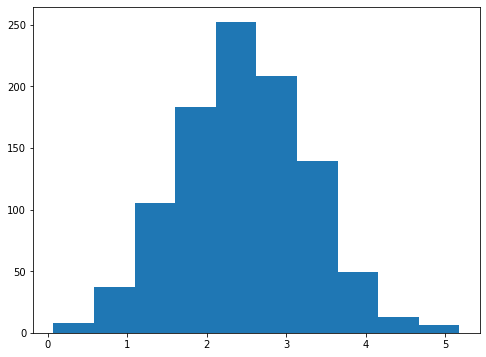

Radius range out of model expectation. Returning None.
6274.01 1.5 0.47 -0.16
6276.01 0.64 0.05 -0.06
6409.01 2.42 1.09 -1.3
0.004812328077827388
6.386861039158872


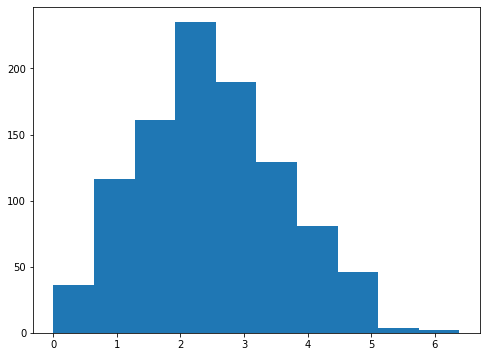

Radius range out of model expectation. Returning None.
0.05041301143120691
4.535528817062823


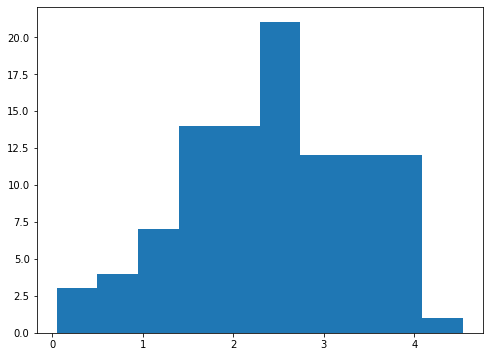

Radius range out of model expectation. Returning None.
6532.01 1.36 0.38 -0.2
6664.01 0.93 0.17 -0.08
6666.01 0.75 0.21 -0.08
6798.01 3.56 2.12 -1.41
0.0023611688903377726
8.61627681196492


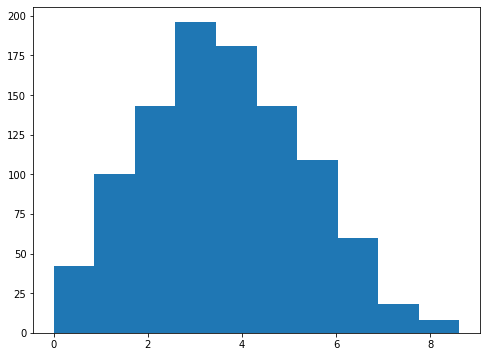

Radius range out of model expectation. Returning None.
0.01546411417667537
7.744420498088372


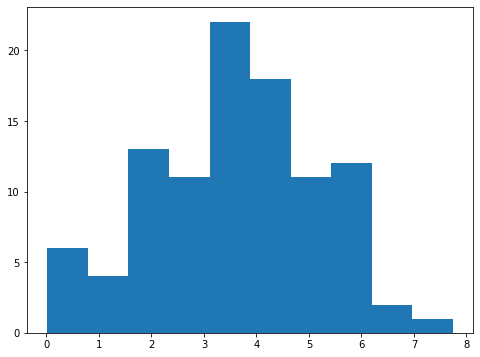

Radius range out of model expectation. Returning None.
6931.01 1.2 0.34 -0.09
7061.01 4.91 2.8 -1.09
7195.01 1.0 0.52 -0.11
7197.01 1.46 0.22 -0.12
7327.01 1.88 0.15 -0.19
7330.01 1.09 0.59 -0.29
0.0059388976471408395
2.325539612631118


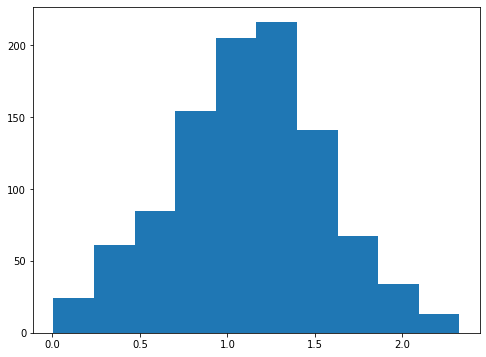

Radius range out of model expectation. Returning None.
7460.01 1.58 0.37 -0.2
6538.01 1.45 0.48 -0.16
6672.01 1.0 0.18 -0.09
6676.01 1.81 0.62 -0.17
6934.01 2.16 0.74 -1.38
0.007393753034177664
6.506304115283175


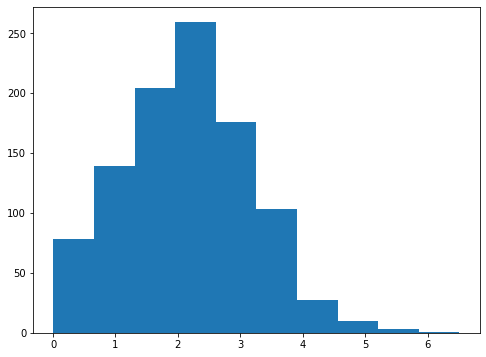

Radius range out of model expectation. Returning None.
7069.01 1.61 0.56 -0.19
7072.01 4.39 0.55 -1.66
7073.01 30.25 5.32 -3.87
7074.01 1.49 0.6 -0.13
7076.01 1.28 0.41 -0.16
7205.01 39.82 8.72 -13.09
7208.01 0.87 0.29 -0.07
7209.01 3.28 0.54 -1.25
7339.01 1.73 0.49 -0.21
7467.01 1.33 0.56 -0.46
0.0038853066175281725
2.7779083476368625


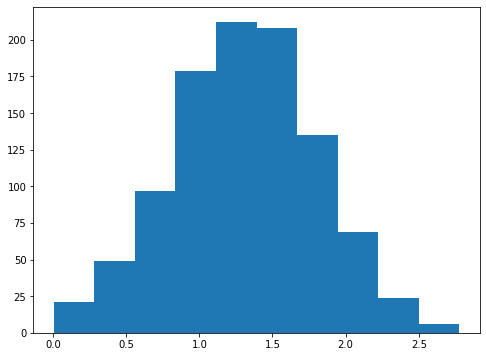

Radius range out of model expectation. Returning None.
0.05822966897998727
2.4999453369287927


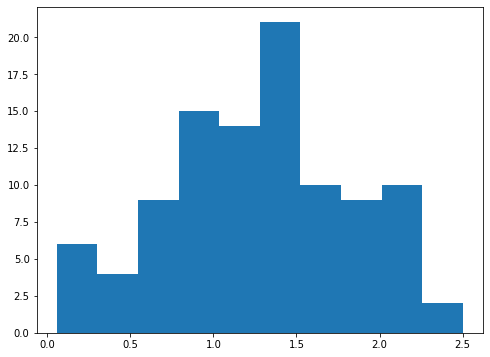

Radius range out of model expectation. Returning None.
7470.01 1.9 2.01 -0.31
0.005960482664981059
5.564733338422749


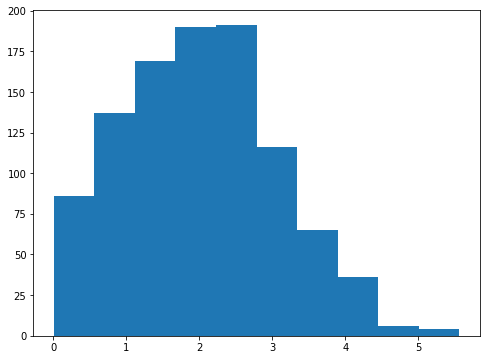

Radius range out of model expectation. Returning None.
0.08769271238940801
4.791975986645037


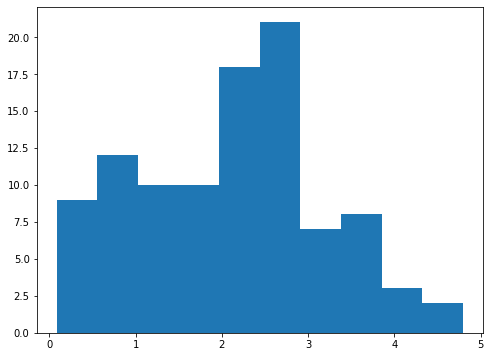

Radius range out of model expectation. Returning None.
7471.01 1.3 0.43 -0.15
6291.01 0.98 0.33 -0.18
6293.01 1.21 0.39 -0.15
6425.01 1.5 0.57 -0.19
6546.01 1.03 0.32 -0.12
6680.01 0.8 0.12 -0.08
6819.01 1.01 0.54 -0.22
0.0989490917773137
2.3349690999782045


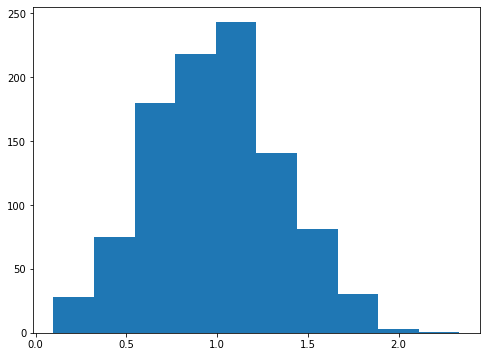

Radius range out of model expectation. Returning None.
0.039815984387895687
1.908590937504412


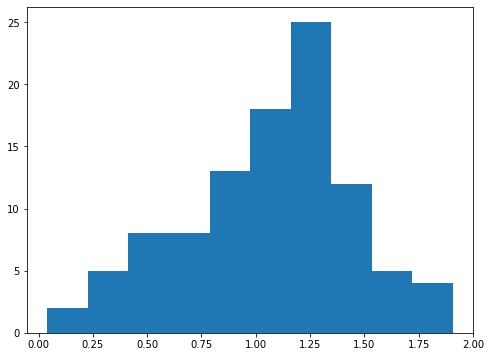

Radius range out of model expectation. Returning None.
6949.01 1.24 0.28 -0.35
7215.01 0.83 0.16 -0.06
7345.01 2.16 0.32 -0.1
7479.01 1.1 0.18 -0.27
6299.01 0.67 0.08 -0.02
6301.01 2.94 0.88 -0.38
7879.01 6.15 0.65 -2.44
6557.01 1.04 0.33 -0.16
6687.01 0.87 0.08 -0.08
6689.01 0.98 0.26 -0.21
0.04606139545754606
1.9793573331268846


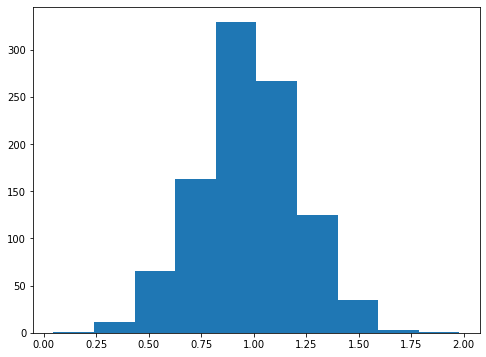

Radius range out of model expectation. Returning None.
6954.01 0.91 0.2 -0.24
6957.01 0.76 0.25 -0.08
7088.01 0.92 0.17 -0.07
7093.01 1.41 0.47 -0.16
7220.01 0.97 0.32 -0.1
7223.01 1.59 0.27 -0.12
7224.01 1.62 0.73 -0.15
7354.01 1.61 0.25 -0.46
7358.01 1.26 0.17 -0.12
7483.01 0.68 0.31 -0.07
7484.01 2.14 0.57 -0.19
7489.01 0.81 0.12 -0.08
6960.01 1.2 0.41 -0.13
6966.01 1.35 0.28 -0.11
7099.01 1.05 0.07 -0.1
7232.01 1.18 0.24 -0.1
7359.01 2.26 0.68 -0.29
7360.01 7.76 3.62 -2.15
7361.01 1.16 0.12 -0.09
126.02 0.73 0.11 -0.17
1106.03 1.5 0.24 -0.14
1110.02 0.84 0.28 -0.09
6315.01 0.7 0.1 -0.07
6318.01 1.26 0.18 -0.09
6320.01 2.36 1.92 -0.46
0.010093558464959962
6.448544852750494


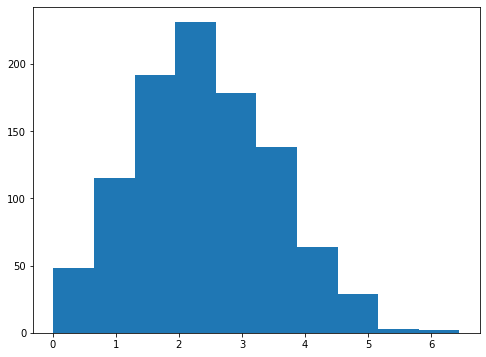

Radius range out of model expectation. Returning None.
0.09798612883441438
4.9876550024617


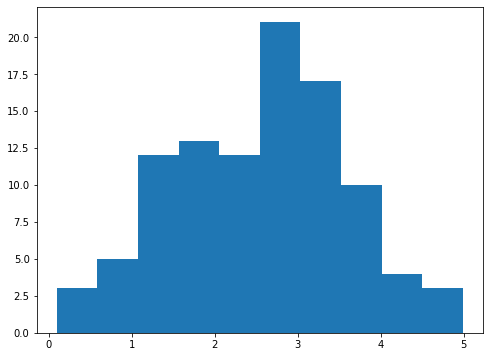

Radius range out of model expectation. Returning None.
6449.01 1.58 0.59 -0.12
6450.01 0.78 0.29 -0.14
6454.01 1.34 0.5 -0.16
6568.01 0.65 0.07 -0.06
6570.01 3.53 1.07 -1.23
6705.01 0.22 0.14 -0.01
0.03679640566908013
0.44354509013616683


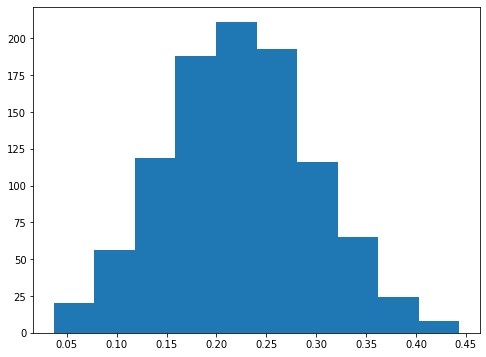

Radius range out of model expectation. Returning None.
0.07536774139750313
0.40557546591842064


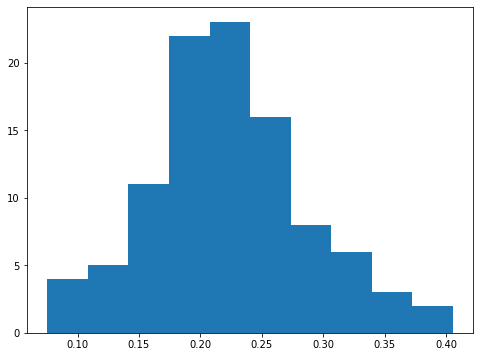

Radius range out of model expectation. Returning None.
0.07779509492035513
0.34444705730595226


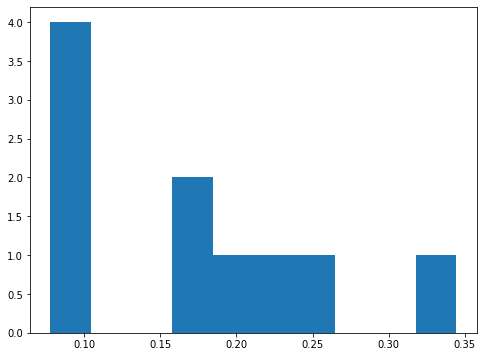

Radius range out of model expectation. Returning None.
0.0712213999110217
0.40567812087288313


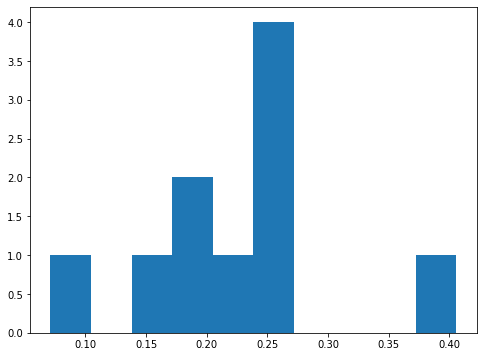

Radius range out of model expectation. Returning None.
0.09346738545246422
0.3059323505616166


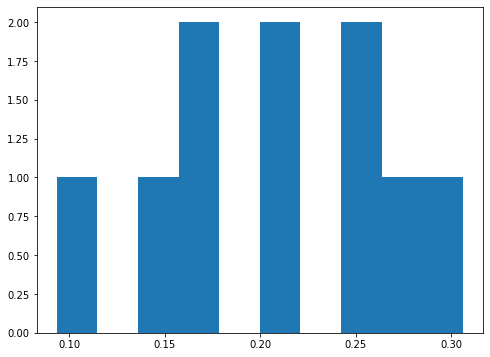

Radius range out of model expectation. Returning None.
6707.01 1.86 0.33 -0.16
7888.01 0.6 0.2 -0.06
6970.01 1.87 0.31 -0.25
6971.01 2.01 0.08 -0.13
7106.01 1.08 0.37 -0.14
7235.01 1.15 0.38 -0.08
7236.01 1.05 0.18 -0.21
7370.01 0.96 0.25 -0.07
7375.01 1.51 0.07 -0.14
7506.01 1.41 0.47 -0.16
1427.02 0.84 0.05 -0.07
1574.04 1.79 0.15 -0.13
1602.02 1.55 0.25 -0.39
1681.04 10.39 1.14 -1.38
1840.02 20.91 3.59 -3.27
6579.01 1.17 0.35 -0.13
6582.01 1.07 0.33 -0.11
6849.01 1.88 0.3 -0.25
6978.01 0.84 0.13 -0.14
6980.01 1.08 0.38 -0.11
6983.01 0.85 0.12 -0.06
7116.01 0.62 0.1 -0.04
7117.01 1.01 0.31 -0.1
7117.02 1.45 0.44 -0.14
7376.01 1.18 0.34 -0.11
7378.01 3.29 0.26 -0.3
7380.01 1.21 0.58 -0.16
7383.01 1.2 0.44 -0.13
7510.01 1.04 0.24 -0.08
2050.02 0.74 0.04 -0.05
2103.02 0.82 0.12 -0.09
2199.02 1.18 0.2 -0.1
2232.02 1.73 0.22 -0.19
2321.02 1.43 0.23 -0.08
2421.02 0.48 0.02 -0.03
2439.02 1.32 0.43 -0.15
2449.02 1.46 0.19 -0.18
6329.01 2.06 0.31 -0.61
0.07144183343913335
3.444389222212999


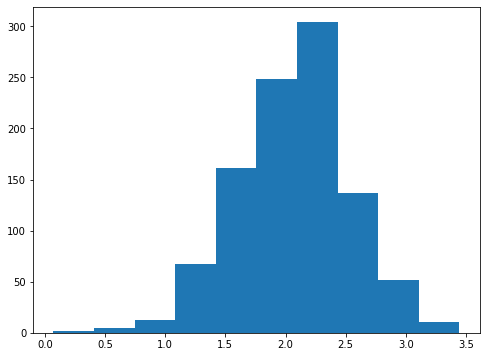

Radius range out of model expectation. Returning None.
6331.01 1.36 0.33 -0.11
6860.01 0.43 0.01 -0.02
6985.01 0.81 0.26 -0.08
7125.01 0.93 0.28 -0.12
7252.01 1.17 0.33 -0.18
7389.01 11.03 0.69 -2.7
7520.01 3.45 0.45 -1.32
2523.02 1.8 0.27 -0.25
2564.02 2.98 0.55 -1.01
2623.02 0.68 0.14 -0.05
2636.02 0.63 0.12 -0.04
283.03 0.73 0.13 -0.06
2756.02 0.92 0.33 -0.09
6342.01 0.83 0.22 -0.15
6343.01 1.96 0.59 -0.2
6475.01 1.54 0.03 -0.09
7880.01 1.81 0.48 -0.26
6600.01 0.69 0.25 -0.09
0.06931058936477763
1.203217055654504


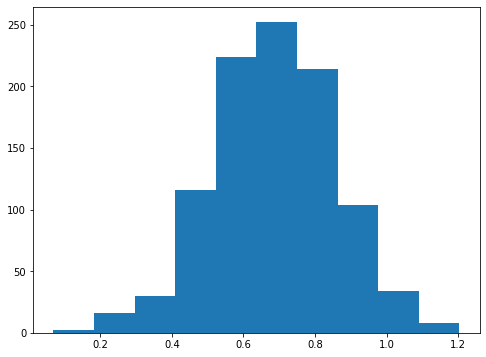

Radius range out of model expectation. Returning None.
6731.01 1.14 0.34 -0.12
6733.01 2.48 0.45 -0.82
6734.01 2.12 0.84 -0.17
6862.01 0.83 0.36 -0.09
6863.01 0.95 0.16 -0.12
6993.01 1.09 0.19 -0.11
6994.01 0.7 0.1 -0.15
7129.01 1.74 0.57 -0.29
7133.01 2.16 0.36 -0.47
7258.01 0.79 0.14 -0.16
7259.01 11.04 0.97 -0.88
7264.01 1.83 0.26 -0.6
7400.01 1.09 0.14 -0.1
3019.02 0.99 0.16 -0.15
3053.02 1.38 0.43 -0.14
3068.02 0.84 0.09 -0.06
3344.03 2.84 0.42 -0.52
3348.02 1.44 0.22 -0.2
3395.02 0.78 0.3 -0.1
0.00019634287484060486
1.3498945603608428


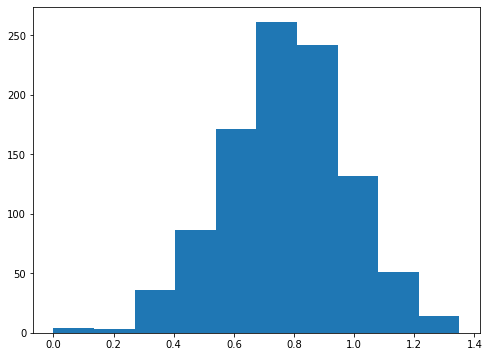

Radius range out of model expectation. Returning None.
3425.03 1.85 0.43 -0.74
0.038423852966140926
3.5870073219915524


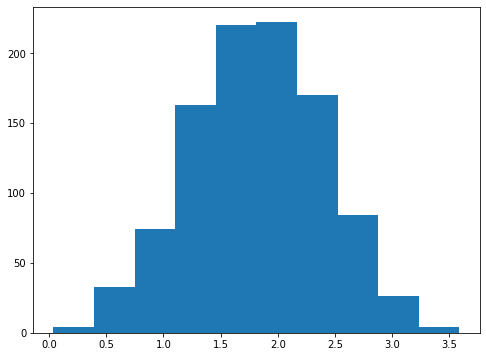

Radius range out of model expectation. Returning None.
6352.01 1.16 0.36 -0.12
6484.01 1.34 0.51 -0.15
6601.01 1.62 0.46 -0.3
6605.01 2.39 1.12 -1.13
0.011213020534902363
6.090629892319056


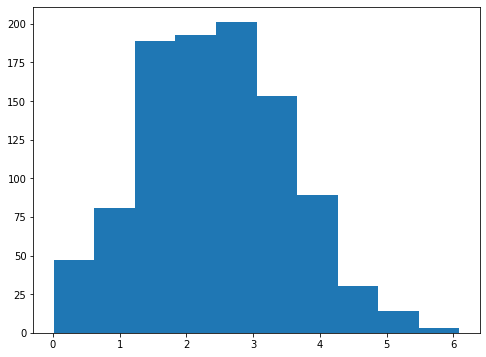

Radius range out of model expectation. Returning None.
6739.01 1.11 0.14 -0.09
6872.01 0.88 0.27 -0.07
7002.01 1.3 0.35 -0.15
7003.01 1.35 0.21 -0.33
7007.01 0.77 0.06 -0.08
7136.01 2.27 0.86 -0.17
7270.01 1.42 0.42 -0.14
7272.01 1.26 0.39 -0.14
7404.01 1.39 0.45 -0.14
7408.01 19.07 0.85 -0.75
7534.01 0.92 0.48 -0.09
0.06451041927041945
1.7525711946019544


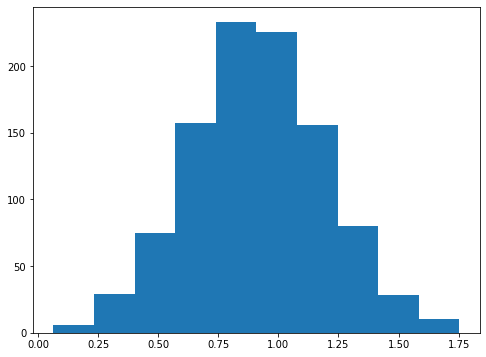

Radius range out of model expectation. Returning None.
7535.01 4.11 0.59 -0.33
7539.01 1.3 0.36 -0.13
7540.01 0.92 0.24 -0.14
2704.03 2.44 1.62 -0.7
0.016477199050207947
6.220964196356846


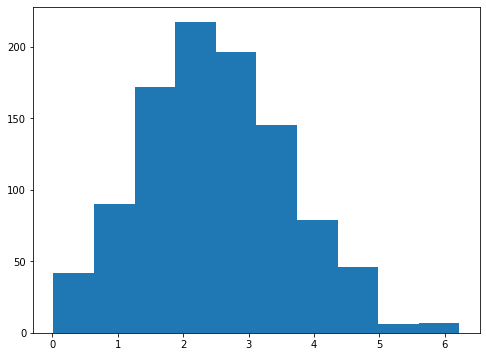

Radius range out of model expectation. Returning None.
0.04731742891852386
4.990458867467394


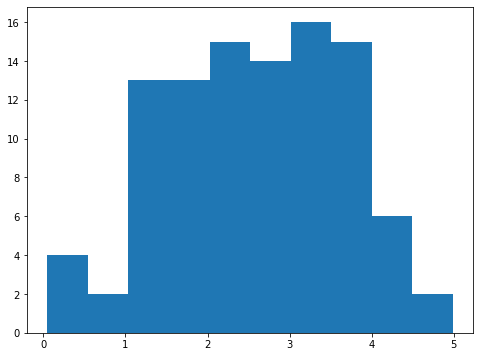

Radius range out of model expectation. Returning None.
4032.05 0.82 0.12 -0.12
4084.02 1.78 0.6 -0.12
4084.03 1.55 0.17 -0.21
4157.02 0.83 0.15 -0.04
6353.01 1.98 0.56 -1.31
0.014315338245555864
4.5844904425449915


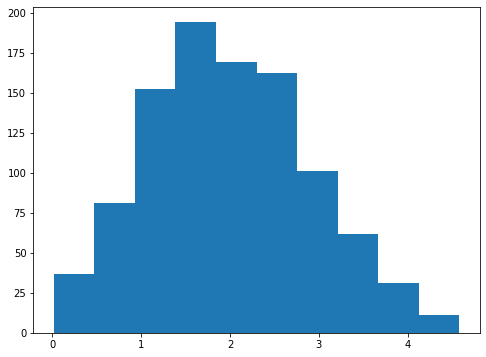

Radius range out of model expectation. Returning None.
6355.01 0.93 0.27 -0.11
6355.02 1.03 0.42 -0.1
6358.01 1.32 0.21 -0.09
6617.01 0.9 0.26 -0.08
6745.01 2.78 1.22 -0.46
6746.01 7.27 2.07 -2.07
6750.01 1.24 0.19 -0.27
6751.01 2.4 0.36 -0.12
6752.01 0.89 0.06 -0.1
6878.01 1.11 0.23 -0.09
6882.01 1.87 0.59 -0.44
7016.01 1.09 0.2 -0.1
7144.01 0.92 0.12 -0.11
7148.01 2.32 0.79 -0.32
7279.01 0.93 0.17 -0.15
7281.01 1.14 0.58 -0.3
0.013541851153953122
2.4692639658381204


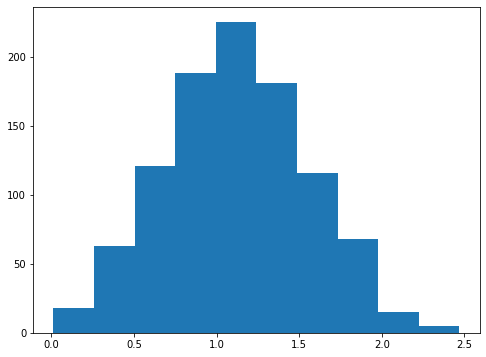

Radius range out of model expectation. Returning None.
0.03636196167205408
2.4383845423554336


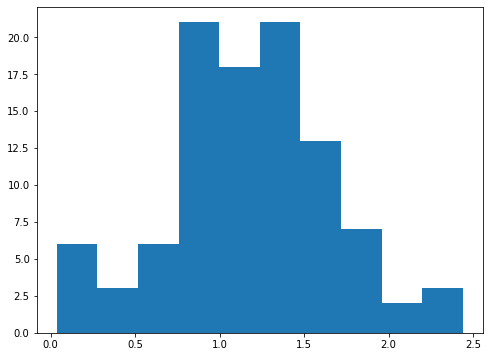

Radius range out of model expectation. Returning None.
0.04131008324327423
1.7465640873021275


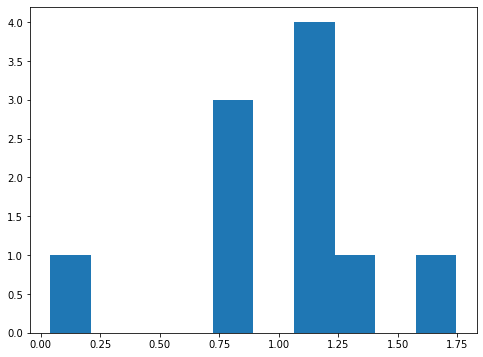

Radius range out of model expectation. Returning None.
7282.01 1.6 0.14 -0.11
566.02 1.1 0.35 -0.11
7415.01 10.97 1.03 -1.03
7416.01 0.97 0.28 -0.23
0.04388669485101537
1.8001061597837578


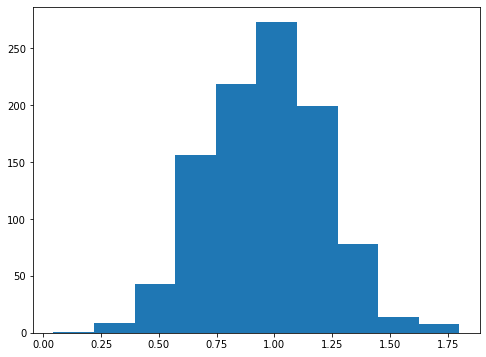

Radius range out of model expectation. Returning None.
4301.02 1.04 0.21 -0.32
4383.02 0.77 0.25 -0.1
4421.02 0.62 0.12 -0.08
416.04 0.74 0.07 -0.02
4500.03 1.7 0.28 -0.17
7617.01 0.64 0.11 -0.12
3184.03 0.6 0.11 -0.11
4524.03 1.2 0.18 -0.09
4782.02 3.66 1.13 -0.37
4957.02 0.73 0.06 -0.08
5447.02 0.68 0.09 -0.03
5475.02 0.97 0.19 -0.29
6447.02 2.27 1.27 -0.54
0.027220359351731727
5.846921157587818


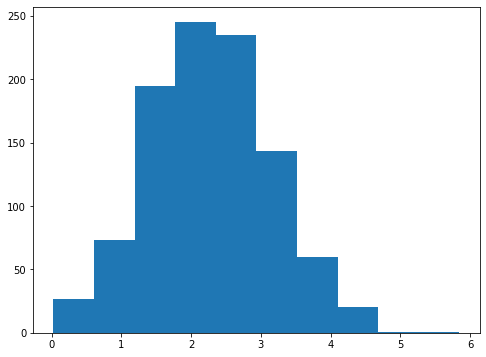

Radius range out of model expectation. Returning None.
6464.03 3.39 0.97 -0.34
7546.01 4.9 0.88 -1.62
7554.01 1.98 1.02 -0.21
0.06690493847947598
4.035306122969389


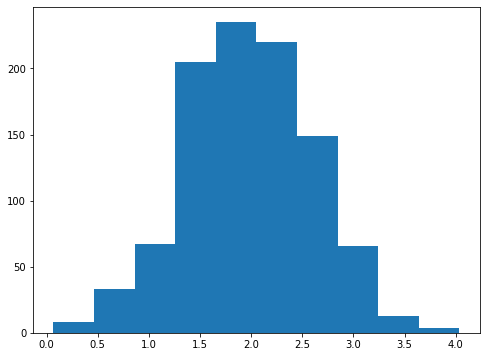

Radius range out of model expectation. Returning None.
7558.01 0.94 0.42 -0.11
0.06326719704744788
1.9015505131168138


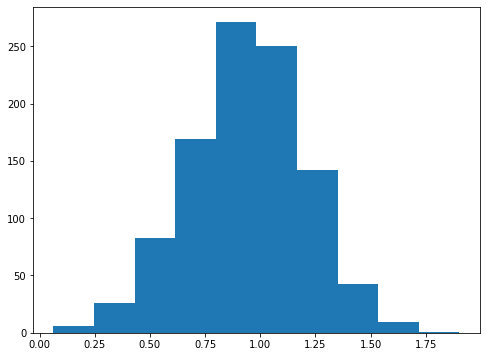

Radius range out of model expectation. Returning None.
7559.01 1.13 0.6 -0.13
0.06587873806453914
2.1885382071919137


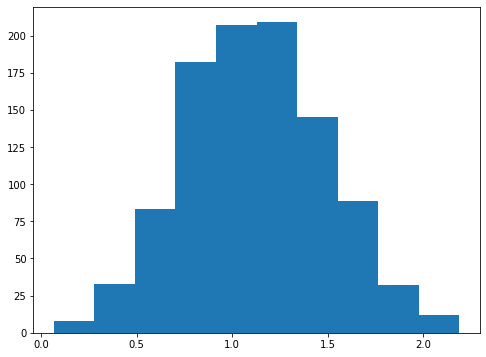

Radius range out of model expectation. Returning None.
7567.01 1.46 0.13 -0.13
2369.03 1.28 0.39 -0.14
7572.01 1.59 0.34 -0.57
7587.01 2.57 0.78 -0.31
7589.01 7.01 4.33 -1.51
2859.05 0.66 0.07 -0.07
7591.01 1.3 0.18 -0.1
7592.01 1.55 0.15 -0.14
7593.01 1.57 0.87 -0.31
0.03654000188382267
3.4696456227498373


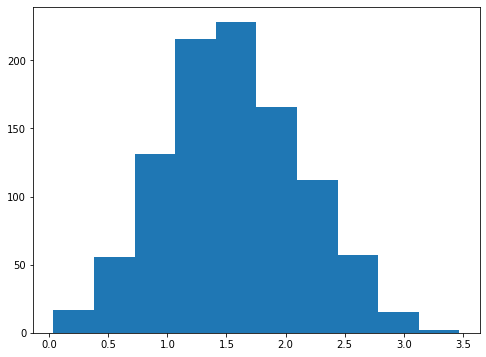

Radius range out of model expectation. Returning None.
7903.01 0.64 0.06 -0.04
7905.01 0.85 0.2 -0.27
7920.01 1.09 0.2 -0.39
7913.01 2.03 0.08 -0.17
7915.01 2.15 0.65 -0.43
8201.01 2.25 0.34 -0.2
8205.01 25.39 1.6 -4.8
7990.01 1.87 0.49 -0.16
7991.01 3.32 0.64 -1.05
7992.01 1.84 0.56 -0.18
8211.01 0.67 0.15 -0.05
7998.01 2.96 0.9 -0.56
8000.01 1.7 0.43 -0.14
8107.01 1.69 0.45 -0.67
0.0806243229200081
3.3745328636707055


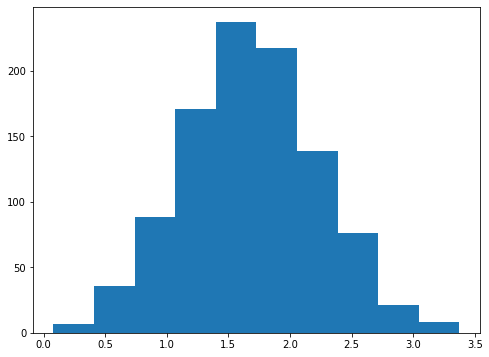

Radius range out of model expectation. Returning None.
8217.01 5.02 1.36 -0.91
8007.01 9.66 1.18 -1.05
8111.01 2.33 0.31 -0.29
8117.01 3.45 1.07 -0.42
8221.01 1.35 0.39 -0.31
0.07050171077445788
2.41862803864338


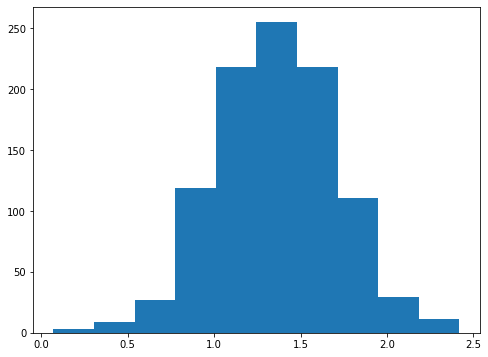

Radius range out of model expectation. Returning None.
8223.01 2.2 0.48 -0.23
8012.01 0.42 0.17 -0.12
0.02799883887560195
0.8864127006164202


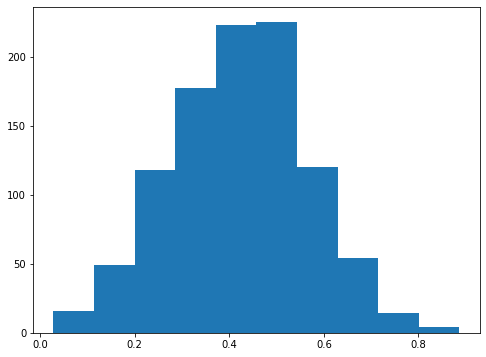

Radius range out of model expectation. Returning None.
0.0026766463693229103
0.8714131597076336


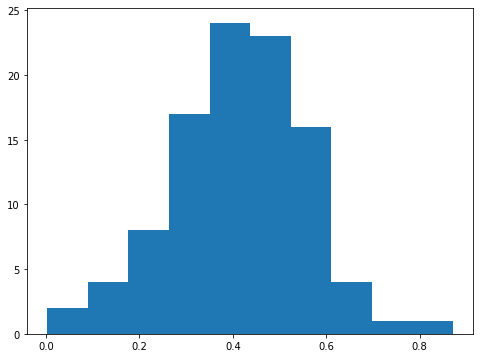

Radius range out of model expectation. Returning None.
8122.01 2.21 0.76 -0.26
8232.01 3.31 0.95 -0.59
8238.01 2.73 0.56 -0.33
8026.01 0.93 0.26 -0.2
8031.01 13.97 0.41 -3.88
8241.01 7.67 0.57 -1.33
8242.01 1.36 0.32 -0.11
8246.01 1.58 0.45 -0.37
0.09272545217880679
3.0209570501022416


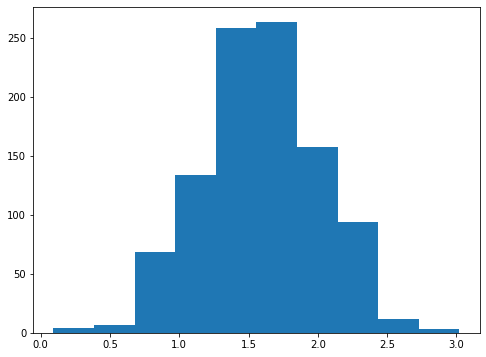

Radius range out of model expectation. Returning None.
7923.01 0.97 0.12 -0.1
7924.01 0.68 0.08 -0.05
7925.01 0.64 0.19 -0.06
8033.01 2.23 0.28 -0.21
8035.01 1.46 0.51 -0.22
8037.01 0.72 0.05 -0.07
8039.01 1.12 0.33 -0.08
8249.01 1.96 0.4 -0.6
8253.01 0.95 0.13 -0.04
7930.01 1.37 0.11 -0.11
7931.01 2.11 0.64 -0.35
7932.01 1.03 0.22 -0.15
8043.01 1.24 0.43 -0.14
8046.01 50.93 3.15 -8.83
8047.01 1.98 0.11 -0.13
8257.01 0.54 0.1 -0.07
8259.01 1.73 0.52 -0.18
7934.01 2.12 0.65 -0.22
7938.01 2.33 0.53 -1.32
0.019191843300014888
4.90566641130259


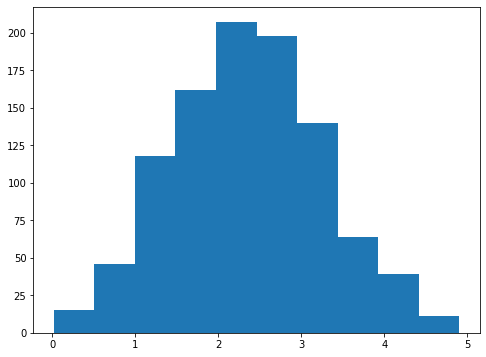

Radius range out of model expectation. Returning None.
7940.01 1.86 0.41 -0.19
8048.01 1.33 0.36 -0.11
8050.01 6.81 1.03 -1.77
8052.01 1.73 0.49 -0.5
8053.01 1.19 0.35 -0.12
8054.01 7.33 1.87 -4.38
0.029617829760367975
17.142579163242555


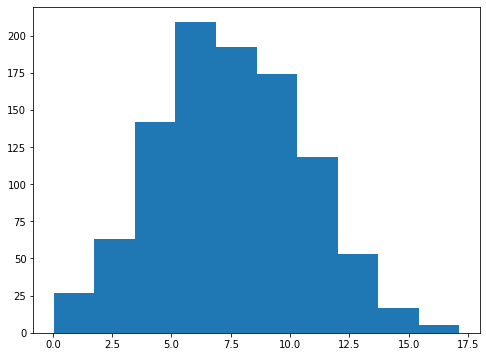

Radius range out of model expectation. Returning None.
8156.01 3.12 1.03 -0.35
8263.01 2.17 0.72 -0.24
8055.01 0.86 0.27 -0.09
8159.02 2.25 0.76 -0.25
8270.01 2.09 0.6 -0.21
8272.01 1.14 0.37 -0.13
7949.01 0.62 0.1 -0.05
7951.01 1.09 0.31 -0.11
7953.01 1.43 0.33 -0.12
7954.01 1.74 0.46 -0.14
8063.01 2.11 0.56 -0.24
8068.01 1.28 0.37 -0.13
8275.01 3.76 0.63 -0.29
8276.01 3.23 1.0 -0.41
8277.01 0.58 0.17 -0.06
8279.01 35.3 12.32 -4.11
8280.01 2.64 0.9 -0.3
8174.01 0.64 0.07 -0.07
8286.01 3.54 0.84 -0.36
8076.01 1.42 0.45 -0.24
8077.01 1.29 0.09 -0.12
8078.01 29.85 3.11 -2.84
8082.01 2.48 0.44 -0.87
8180.01 2.76 0.26 -1.38
0.0739017399805939
5.452544685145625


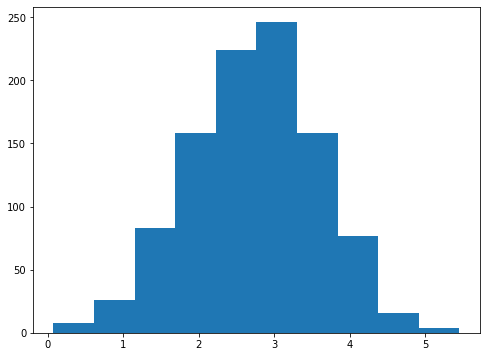

Radius range out of model expectation. Returning None.
8183.01 0.6 0.19 -0.06
7970.01 1.28 0.28 -0.11
7976.01 1.21 0.36 -0.15
8085.01 1.7 0.46 -0.31
8089.01 41.55 1.24 -3.3
8297.01 43.78 7.77 -10.66
7978.01 1.66 0.4 -0.74
0.05272987233781978
3.4032201867181793


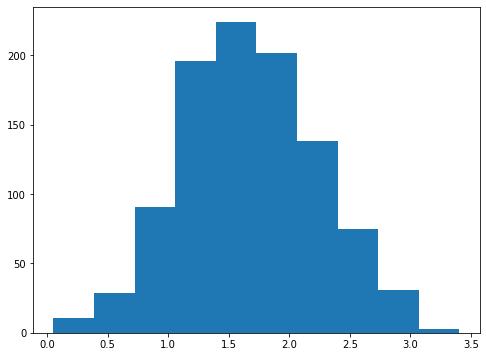

Radius range out of model expectation. Returning None.
7982.01 3.26 1.0 -0.33
8193.01 3.72 0.9 -0.3
7986.01 0.72 0.24 -0.08
7988.01 19.3 0.55 -4.68


In [6]:
# assign mass predictions to all the kois
print(len(KOIs))

Mp = np.zeros(len(KOIs['kepoi_name']))
Mpplus = np.zeros(len(KOIs['kepoi_name']))
Mpminus = np.zeros(len(KOIs['kepoi_name']))

for i in range(0,len(KOIs['kepoi_name'])):
#for i in range(10):
    koiname = KOIs['kepoi_name'][i]
    r = KOIs['koi_prad'][i]
    rUp = KOIs['koi_prad_err1'][i]
    rDown = KOIs['koi_prad_err2'][i]
    
    koi = float(koiname.split("K")[1])

    koiMask = (ms['KOI'] ==  koi)
    
    mArr = str(ms[koiMask]['Mp'])

    try: #use mass prediction from Jingjing's paper
        mArr = mArr.split('[')[1]
        mArr = mArr.split(']')[0]
        mArr = mArr.split(",")

        mLow = 10.**float(mArr[1])
        mMid = 10.**float(mArr[2])
        mUp = 10.**float(mArr[3])

        Mp[i] = mMid
        Mpplus[i] = mUp - mMid
        Mpminus[i] = mMid - mLow
        
    except IndexError: #make our own mass prediction
        print(koi,r,rUp,rDown)
        #print(r,rUp,rDown)
        rAvgUnc = 0.5*(np.abs(rUp) + np.abs(rDown)) 
        #print(r+rAvgUnc)
        #print(r-rAvgUnc)
        
        if rAvgUnc < 0.01:
            rAvgUnc = 0.01
        
        try:
            Mp[i], Mpplus[i], Mpminus[i] = mr.Rstat2M(mean=r, std=rAvgUnc, unit='Earth', sample_size=1000, grid_size=1000, classify = 'No')
        except TypeError:
            try:
                Mp[i], Mpplus[i], Mpminus[i] = mr.Rstat2M(mean=r, std=rAvgUnc, unit='Earth', sample_size=100, grid_size=1000, classify = 'No')
            except TypeError:
                result = None
                while result is None:
                    try:
                        Mp[i], Mpplus[i], Mpminus[i] = mr.Rstat2M(mean=r, std=rAvgUnc, unit='Earth', sample_size=10, grid_size=1000, classify = 'No')
                        result = 1
                    except TypeError:
                        pass
                
        
        

In [7]:
KOIs['koi_pmass'] = Mp
KOIs['koi_pmass_err1'] = Mpplus
KOIs['koi_pmass_err2'] = Mpminus

KOIs = KOIs[(KOIs['koi_pmass'] > 0.)]
print(len(KOIs))

4588


In [8]:
print(np.min(KOIs['koi_smass']))
print(np.max(KOIs['koi_smass']))


0.096
3.573


In [9]:
print(len(KOIs))
#get rid of nans
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_steff']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_slogg']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_smet']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_ror']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_prad']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_pmass']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_insol']))]
KOIs = KOIs[KOIs['koi_insol'] > 0.]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_srad']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_smass']))]
KOIs = KOIs[np.isfinite(np.array(KOIs['koi_period']))]

print(len(KOIs))

4588
4588


In [10]:
# Make sure mass is defined
KOIs = KOIs[(KOIs['koi_pmass'] > 0.)]
print(len(KOIs))

# Eliminate unphysically high radii
KOIs = KOIs[(KOIs['koi_prad'] < 100.)]
print(len(KOIs))

# Eliminate unphysically high masses (cutoff = 0.08 solar masses, boundary between planets & stars in Chen & Kipping)
KOIs = KOIs[(KOIs['koi_pmass'] < 2.7e4)]
print(len(KOIs))

4588
4588
4482


2190.7010353


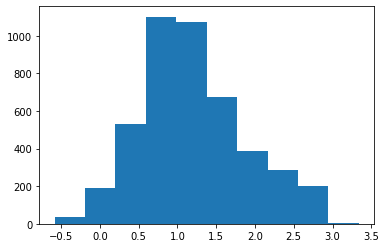

In [13]:
plt.hist(np.log10(KOIs['koi_period']))
print(np.max(KOIs['koi_period']))


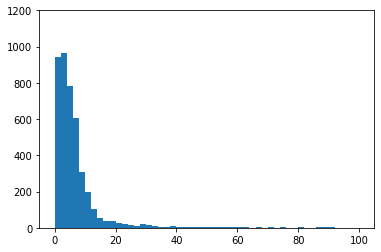

25703.957827688646


In [14]:

plt.hist(KOIs["koi_pmass"],range=(0.,100.),bins=50)
plt.ylim(0.,1200.)
plt.show()

print(np.max(KOIs['koi_pmass']))

In [15]:
print(np.min(KOIs['koi_prad']))
print(np.max(KOIs['koi_prad']))

0.22
96.08


In [16]:
bad_ids = []
kepids = np.unique(KOIs['kepid'])
for k in kepids:
    thisSys_mask = (KOIs['kepid']==k)
    thisSys = KOIs[thisSys_mask]
    if len(thisSys) != thisSys['koi_count'][0]:
        print("yikes!")
        print(k)
        print(thisSys['kepoi_name'][0])
        bad_ids.append(k)

bad_ids = np.array(bad_ids)

good_idxs = []
for i in range(len(KOIs['kepid'])):
    if (KOIs['kepid'][i] not in bad_ids):
        good_idxs.append(i)

good_idxs = np.array(good_idxs)
KOIs = KOIs[good_idxs]

print(len(KOIs))

yikes!
2438513
K01944.01
yikes!
2446113
K00379.02
yikes!
2716853
K01022.01
yikes!
2852810
K06097.02
yikes!
2852941
K04298.01
yikes!
2853780
K02081.01
yikes!
2861126
K04957.02
yikes!
3229028
K06100.02
yikes!
3231341
K01102.02
yikes!
3348082
K01196.02
yikes!
3447722
K01198.01
yikes!
3547760
K04535.02
yikes!
3561464
K03398.01
yikes!
3634051
K06103.01
yikes!
3662838
K00302.01
yikes!
3832474
K00806.01
yikes!
4078157
K01319.02
yikes!
4164922
K03864.02
yikes!
4247991
K02311.03
yikes!
4349442
K01803.01
yikes!
4367854
K02876.01
yikes!
4548011
K04288.04
yikes!
4735826
K03184.01
yikes!
4758350
K06447.02
yikes!
4857058
K03061.02
yikes!
4862625
K06464.03
yikes!
4919550
K04766.01
yikes!
4953173
K04676.01
yikes!
5092799
K06516.01
yikes!
5308663
K01562.02
yikes!
5351250
K00408.01
yikes!
5384713
K03444.01
yikes!
5385410
K04323.01
yikes!
5446285
K00142.01
yikes!
5474613
K01599.01
yikes!
5526717
K01677.01
yikes!
5544450
K03226.02
yikes!
5546761
K02160.01
yikes!
5642620
K02882.01
yikes!
5816144
K06137.01


In [18]:
#print(np.max(KOIs['koi_count']))
print(len(KOIs))
nsys = 0
for i in range(1,8):
    nsys_i = len(KOIs[KOIs['koi_count'] == i])/i
    print(nsys_i)
    nsys += nsys_i

print(nsys)

ascii.write(KOIs, 'KOIs_chen2018_goodSystems_incJupiters.csv', format='csv', fast_writer=False, overwrite=True)


4286
2601.0
448.0
151.0
53.0
21.0
2.0
1.0
3277.0


In [19]:
2601 + (2*448) + (3*151) + (4*53) + (5*21) + (6*2) + (7*1)

4286

In [20]:
2601 + 448 + 151 + 53 + 21 + 2 + 1

3277

In [21]:
a=KOIs['koi_sma']
aerr_up = np.array(KOIs['koi_sma_err1'])
aerr_down = np.array(KOIs['koi_sma_err2'])
aerr = np.vstack((aerr_down.T,aerr_up.T))

Rp = np.array(KOIs['koi_prad'])
Rperr_up = np.array(KOIs['koi_prad_err1'])
Rperr_down = np.array(KOIs['koi_prad_err2'])
Rperr = np.vstack((Rperr_down.T,Rperr_up.T))

Mp = np.array(KOIs['koi_pmass'])
Mperr_up = np.array(KOIs['koi_pmass_err1'])
Mperr_down = np.array(KOIs['koi_pmass_err2'])

#convert masses from Earth to Jupiter masses
Mp = Mp*u.Mearth
Mp = Mp.to(u.Mjup)
Mp = Mp.value

Mperr_up = Mperr_up * u.Mearth
Mperr_up = Mperr_up.to(u.Mjup)
Mperr_up = Mperr_up.value

Mperr_down = Mperr_down * u.Mearth
Mperr_down = Mperr_down.to(u.Mjup)
Mperr_down = Mperr_down.value

Mperr = np.vstack((Mperr_down.T,Mperr_up.T))


/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


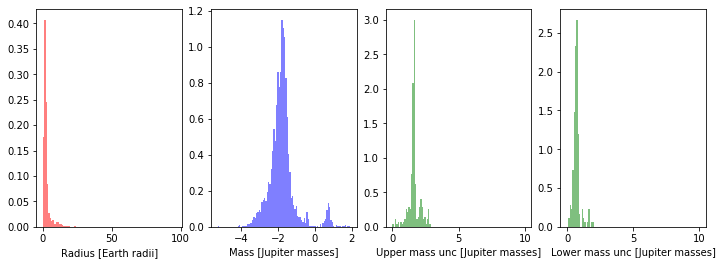

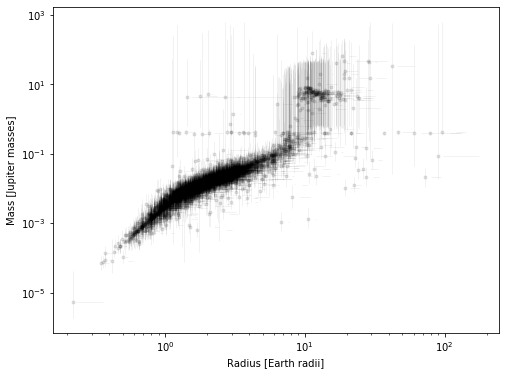

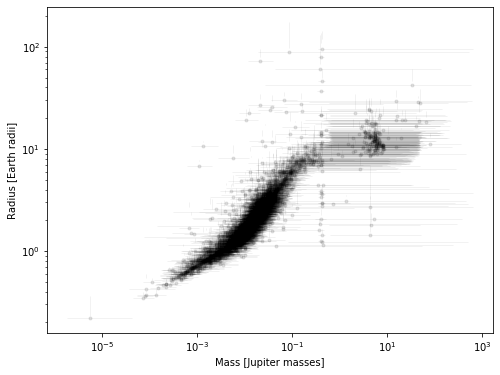

In [22]:
fig,axes = plt.subplots(1,4,figsize=(12,4))
axes[0].hist(Rp,bins=100,normed=True,color='r',alpha=0.5)
axes[0].set_xlabel("Radius [Earth radii]")
axes[1].hist(np.log10(Mp),bins=100,normed=True,color='b',alpha=0.5)
axes[1].set_xlabel("Mass [Jupiter masses]")
axes[2].hist(np.log10(Mperr_up),bins=100,range=(0.,10.),normed=True,color='g',alpha=0.5)
axes[2].set_xlabel("Upper mass unc [Jupiter masses]")
axes[3].hist(np.log10(Mperr_down),bins=100,range=(0.,10.),normed=True,color='g',alpha=0.5)
axes[3].set_xlabel("Lower mass unc [Jupiter masses]")
plt.show()

fig = plt.figure(figsize=(8,6))
plt.errorbar(Rp,Mp,xerr=Rperr,yerr=Mperr,marker='.',ls='None',color='k',capsize=0.,elinewidth=0.5,alpha=0.1)
plt.xlabel("Radius [Earth radii]")
plt.ylabel("Mass [Jupiter masses]")
plt.loglog()
plt.show()

fig = plt.figure(figsize=(8,6))
plt.errorbar(Mp,Rp,xerr=Mperr,yerr=Rperr,marker='.',ls='None',color='k',capsize=0.,elinewidth=0.5,alpha=0.1)
plt.ylabel("Radius [Earth radii]")
plt.xlabel("Mass [Jupiter masses]")
plt.loglog()
plt.show()

In [23]:
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [24]:
def makeCmap(hexColour,name,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(name,cdict)
    return cmap

pulsarCmap=makeCmap('#36747D','name')#,zeroColour='#91B3B8')
rvCmap=makeCmap('#003049','name1')#,zeroColour='#738E9B')
transitCmap=makeCmap('#7A1809','name2')#,zeroColour='#B68178')
ttvCmap=makeCmap('#BF3E0B','name3')#,zeroColour='#DC9579')
astrometryCmap=makeCmap('#2E8B57','name4')#,zeroColour='#8DBFA3')
etvCmap=makeCmap('#F6AA1C','name5')#,zeroColour='#FAD083')
microlenseCmap=makeCmap('#2168B0','name6')#,zeroColour='#85ACD3')
ptvCmap=makeCmap('#32127A','name7')#,zeroColour='#8F7DB6')
transitCmap=makeCmap('#F6511D','name2')
rvCmap=makeCmap('#0D2C54','name1')
microlenseCmap=makeCmap('#00A6ED','name6')
imageCmap=makeCmap('#FFB400','name6')
otherCmap=makeCmap('#7FB800','name8')

nPlanets = len(Mp)
colours=np.zeros((nPlanets,4))
ID = np.arange(nPlanets)
maxPlanets=np.max(ID)

#others=np.argwhere((mths!=9)&(mths!=7)&(mths!=3)&(mths!=2))
transits=np.where(Mp > 0.)
#rvs=np.argwhere(mths==2)
#microlenses=np.argwhere(mths==7)
#images=np.argwhere(mths==9)
#pulsars=np.argwhere(mths==1)

colours=otherCmap(0.25+(3*ID/maxPlanets))
colours[transits]=transitCmap(1.)
#colours[rvs]=rvCmap(0.25+(3*ID[rvs]/maxPlanets))
#colours[microlenses]=microlenseCmap(0.25+(3*ID[microlenses]/maxPlanets))
#colours[images]=imageCmap(0.25+(3*ID[images]/maxPlanets))

In [25]:
aTicks=[0.002,1/215,0.012,0.387,1,5.2,30.1,100,5000]
aLabels=[r'$Io$',r'$R_\odot$',r'$Callisto$','Mercury','Earth','Jupiter','Neptune','Eris','Oort Cloud']
mTicks=[0.00033,1/317,0.1,1]
mLabels=['Mars','Earth','Neptune','Jupiter']
eTicks=[0.0086,0.0167,0.0484,0.2056,0.9671]
eLabels=['Neptune','Earth','Jupiter','Mercury',"Halley's Comet"]
eSolar=[0.2056,0.0068,0.0167,0.0934,0.0484,0.0541,0.0472,0.0086]
mSolar=[1/5750,0.002,0.003,0.00033,1,0.3,0.046,0.054]
aSolar=[0.387,0.72,1,1.52,5.2,9.58,19.23,30.1]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


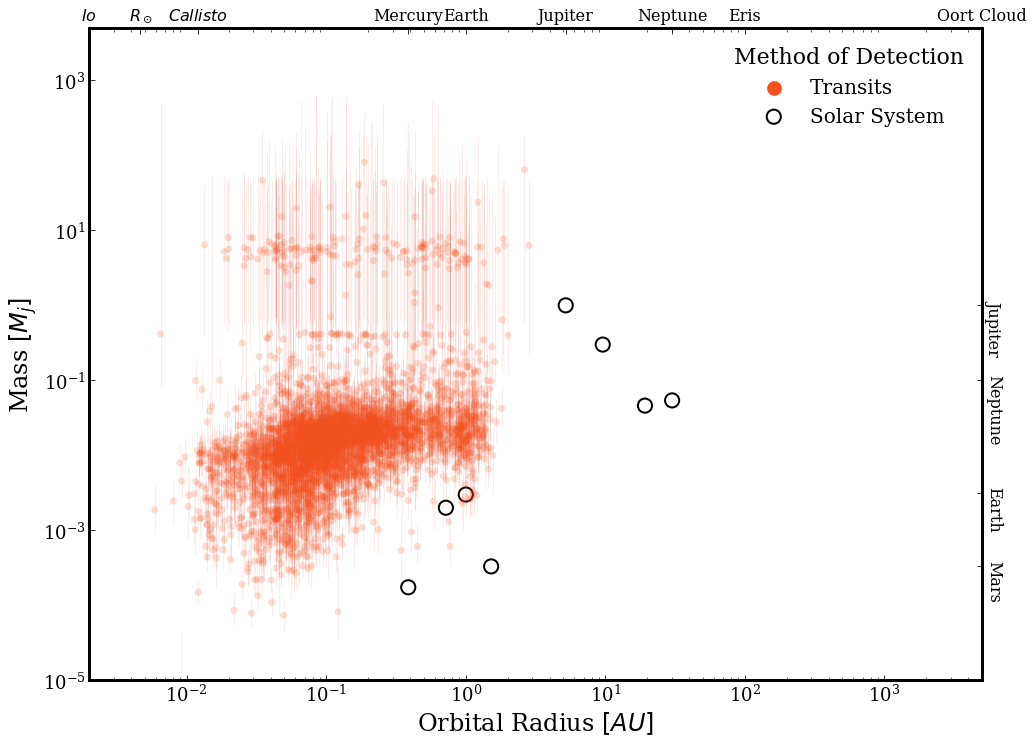

In [27]:
ampFig = plt.figure(figsize=(16,12))
ampPlot=plt.gca()

aPlot = ampPlot.twiny()
aPlot.set_xscale('log')
aPlot.set_xticks(aTicks)
aPlot.set_xticklabels(aLabels,fontsize=16)
aPlot.set_xlim(aTicks[0],aTicks[-1])
aPlot.grid(False)
mPlot= ampPlot.twinx()
mPlot.grid(False)
mPlot.set_yscale('log')
mPlot.set_yticks(mTicks)
mPlot.set_yticklabels(mLabels,fontsize=16,rotation=270)
mPlot.set_ylim(1.e-5,5000)

ampPlot.errorbar(a,Mp,xerr=aerr,yerr=Mperr,marker='None',linestyle='None',capsize=0.,elinewidth=0.5,alpha=0.2)
ampPlot.scatter(a,Mp,s=50,c=colours,zorder=3,edgecolors='None',alpha=0.2)
ampPlot.set_xscale('log')
ampPlot.set_xlim(aTicks[0],aTicks[-1])
ampPlot.set_xlabel('Orbital Radius $[AU]$',fontsize=24)
ampPlot.tick_params(labelsize=18)
#ampPlot.set_xticks(aTicks)
#ampPlot.set_xticklabels(aLabels,fontsize=14)

ampPlot.set_yscale('log')
ampPlot.set_ylim(1.e-5,5000)
ampPlot.set_ylabel('Mass $[M_j]$',fontsize=24)

ampPlot.scatter([1e-20,1e-20],[1,1],s=200,c=transitCmap(1.),label='Transits')
ampPlot.scatter(aSolar,mSolar,s=200,facecolors='none', edgecolors='k',lw=2,label='Solar System')
leg=ampPlot.legend(loc=0,ncol=1,frameon=False,fontsize=20,title="Method of Detection")
leg.get_title().set_fontsize('22')
#plt.show()
plt.savefig('KOIs_chen2018_goodSystems_incJupiters.png')